In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# ----------------------------
# 1. Improved ScriptNetEnhancedV2
# ----------------------------
def build_scriptnet_enhanced(input_shape=(32, 32, 1), num_classes=47):
    inputs = Input(shape=input_shape, name='input_layer')


    def conv_block(x, filters, kernel_size=(3, 3), pool=True):
        x = SeparableConv2D(
            filters, kernel_size,
            padding='same',
            depthwise_regularizer=l2(1e-4),
            pointwise_regularizer=l2(1e-4)
        )(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if pool:
            x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.3)(x)
        return x


    x = conv_block(inputs, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)

    x = Flatten()(x)
    x = Dense(512, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    return Model(inputs=inputs, outputs=outputs, name='ScriptNetEnhancedV2')


In [7]:
import pandas as pd
import cv2
from tqdm import tqdm

# ---------------------------------------------
# Step 2: Convert EMNIST CSV to Image Folders (32x32)
# ---------------------------------------------
def save_emnist_images(csv_path, output_dir, img_size=(32, 32)):
    os.makedirs(output_dir, exist_ok=True)

    df = pd.read_csv(csv_path, header=None)
    labels = df.iloc[:, 0].values.astype(int)
    images = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8')

    for idx, (label, image) in enumerate(tqdm(zip(labels, images), total=len(labels))):
        label_dir = os.path.join(output_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)

        # Rotate + flip to fix EMNIST orientation
        image = np.transpose(image, (1, 0))
        image = cv2.flip(image, 0)

        # Resize to 32x32
        image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)

        img_path = os.path.join(label_dir, f"{idx}.png")
        cv2.imwrite(img_path, image)

# Convert train and test CSVs to image folders
save_emnist_images('/kaggle/input/emnist/emnist-balanced-train.csv', 'emnist_balanced_images/train')
save_emnist_images('/kaggle/input/emnist/emnist-balanced-test.csv', 'emnist_balanced_images/test')

# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 60
num_classes = 47  # Update if using fewer classes

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=(0.9, 1.1),
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'emnist_balanced_images/train',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',  # change from 'sparse' to 'categorical'
    subset='training',
    seed=42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    'emnist_balanced_images/train',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

100%|██████████| 18800/18800 [00:03<00:00, 4701.92it/s]


Found 90240 images belonging to 47 classes.
Found 22560 images belonging to 47 classes.


In [8]:
from tensorflow.keras.layers import SeparableConv2D

# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet_enhanced(input_shape=input_shape, num_classes=num_classes)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

model.summary()

I0000 00:00:1748747730.616863      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748747730.617604      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNetEnhancedV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 32, 32, 64)          │             137 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_3 (SeparableConv2D) │ (None, 16, 16, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 8, 8, 256)           │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,168,824 (8.27 MB)

 Trainable params: 2,166,904 (8.27 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [9]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    ModelCheckpoint("scriptnet_emnist_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

# ----------------------------
# 5. Train Model
# ----------------------------

steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1748747833.102740     130 service.cc:148] XLA service 0x7c59c40161a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748747833.107708     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748747833.107741     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748747834.094268     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/1410 ━━━━━━━━━━━━━━━━━━━━ 1:03 45ms/step - accuracy: 0.0345 - loss: 4.8246

I0000 00:00:1748747842.475294     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1409/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1785 - loss: 3.5701
Epoch 1: val_accuracy improved from -inf to 0.64176, saving model to scriptnet_emnist_best.h5
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 93s 55ms/step - accuracy: 0.1787 - loss: 3.5694 - val_accuracy: 0.6418 - val_loss: 1.8992 - learning_rate: 1.0000e-04
Epoch 2/60
1409/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4735 - loss: 2.3797
Epoch 2: val_accuracy improved from 0.64176 to 0.76427, saving model to scriptnet_emnist_best.h5
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 74s 53ms/step - accuracy: 0.4736 - loss: 2.3796 - val_accuracy: 0.7643 - val_loss: 1.5723 - learning_rate: 1.0000e-04
Epoch 3/60
1409/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5994 - loss: 2.0144
Epoch 3: val_accuracy improved from 0.76427 to 0.80173, saving model to scriptnet_emnist_best.h5
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 73s 52ms/step - accuracy: 0.5994 - loss: 2.0144 - val_accuracy: 0.8017 - val_loss: 1.4758 - learning_rate: 1.0000e-04
Epoch 4/6

NameError: name 'history' is not defined

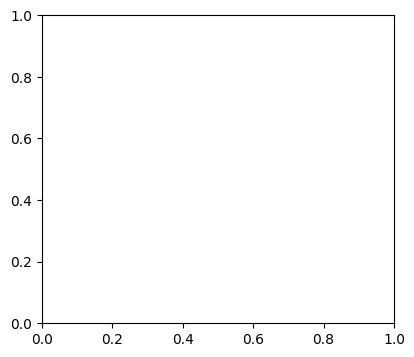

In [1]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# plot the convergence, in terms of accuracy and loss, of ScriptNet
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
plt.figure(figsize=(12, 12))
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# true and predicted labels
cm = confusion_matrix(y_true, y_pred, labels=range(47))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(cm_normalized, annot=False, cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30, 25))  # Bigger figure
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title('Confusion Matrix (84 Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=range(0, 47, 5), labels=range(0, 47, 5), rotation=90)  # Sparse ticks
plt.yticks(ticks=range(0, 47, 5), labels=range(0, 47, 5))
plt.show()


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


In [ ]:
# Now exit the session
import os
os._exit(0)
